In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set(font_scale=1.5, palette='Set2')
warnings.filterwarnings("ignore")
%matplotlib inline


## 1. Чтение и изучение данных

Читаем данные с помощью `pandas` и делим их на признаки и целевую метку.

In [3]:
data = pd.read_csv('train.csv')
data = data.drop("client_id", axis=1)
label_encoder = LabelEncoder()

data, labels = data.iloc[:, :-1], np.array(data['credit_rating'])

Читаем также тестовые данные и истинные ответы к ним. Их будем использовать только для финального сравнения

In [7]:
x_test = pd.read_csv('test.csv')
x_test = x_test.drop("client_id", axis=1)

In [8]:
data.head()

,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,delay_from_due_date,number_delayed_payment,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,client_behaviour,monthly_balance
0,Февраль,NaN,NaN,34811.50,2977.666667,2,4,6.0,1.0,3,4.0,2.0,605.03,24.464031,26 г. 7 м.,No,104.291825,"Малые траты, малые платежи",463.220627
1,Март,28.0,Учитель,34231.28,2991.866667,2,4,6.0,1.0,7,1.0,2.0,605.03,38.550848,26 г. 8 м.,No,40.391238,"Большие траты, большие платежи",478.941214
2,Апрель,28.0,Учитель,NaN,2979.906667,2,1385,6.0,1.0,3,NaN,2.0,605.03,33.224951,26 г. 9 м.,No,58.515976,"Большие траты, большие платежи",464.256476
3,Май,28.0,Учитель,34376.73,NaN,2,4,6.0,1.0,3,NaN,2.0,605.03,39.182656,26 г. 10 м.,No,99.306228,"Малые траты, средние платежи",457.656224
4,Июнь,28.0,Учитель,34415.88,2958.436667,2,4,6.0,1.0,3,1.0,2.0,605.03,34.977895,26 г. 11 м.,No,130.115420,"Малые траты, малые платежи",443.497032


In [9]:
data.tail()

,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,delay_from_due_date,number_delayed_payment,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,client_behaviour,monthly_balance
63995,Май,45.0,Медиаменеджер,15962.71,1510.639167,1,1,5.0,4.0,1,NaN,8.0,897.16,36.132095,21 г. 4 м.,No,199.988581,"Малые траты, малые платежи",197.400775
63996,Июнь,NaN,Медиаменеджер,16518.23,1504.069167,1,1,5.0,4.0,1,0.0,8.0,897.16,37.788217,21 г. 5 м.,No,64.549748,"Малые траты, большие платежи",310.219608
63997,Июль,45.0,Медиаменеджер,16081.07,1495.929167,1,1,5.0,4.0,1,NaN,8.0,897.16,24.972853,21 г. 6 м.,No,NaN,"Малые траты, малые платежи",224.671539
63998,Август,45.0,Медиаменеджер,NaN,1455.459167,1,1,5.0,4.0,1,NaN,8.0,897.16,36.166925,21 г. 7 м.,No,NaN,"Малые траты, малые платежи",339.924834
63999,Сентябрь,45.0,Медиаменеджер,16097.00,NaN,1,1,5.0,4.0,1,0.0,8.0,897.16,41.212367,NaN,No,70.805550,"Малые траты, большие платежи",304.383806


Таргет

In [10]:
labels

array(['Обычный', 'Хороший', 'Обычный', ..., 'Хороший', 'Хороший',
       'Хороший'], dtype=object)

Найдем номера категориальных признаков.
Данная процедура, вообще говоря, не гарантирует правильный ответ, но никакой информации о признаках в соревновании не дается

In [11]:
text_features = []
real_features = []

for name in data.columns:
    value = data[name].iloc[0]
    
    if np.isreal(value):
        real_features.append(name)
    else:
        text_features.append(name)
        
print(text_features)
print(real_features)

['month', 'credit_history_age', 'min_amount_payment', 'client_behaviour']
['age', 'occupation', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']


Выданные данные разобьем на обучающие и валидационные

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(
    data, labels, test_size=0.2, random_state=42,
)

## 2. Преобразования данных

Все категориальные признаки преобразуем к строковому типу. При такой процедуре все значения `np.nan` заменяются на строку `nan`, что эквивалентно введению еще одной категории.

In [13]:
x_train[text_features] = x_train[text_features].astype(str)
x_valid[text_features] = x_valid[text_features].astype(str)
x_test[text_features] = x_test[text_features].astype(str)

В зависимости от требований модели к данным разные модели будем обучать на данных с различным препроцессингом. 

**Данные A** &mdash; оригинальные данные, в которых только заменены пропуски в категориальных признаках на строку `nan`. По сути в данных ничего не изменилось.

In [14]:
x_train_origin = x_train.copy()
x_valid_origin = x_valid.copy()
x_test_origin = x_test.copy()

Модели из `sklearn` не умеют обрабатывать пропуски, а они в данных есть:

In [15]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51200 entries, 43820 to 56422
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   month                     51200 non-null  object 
 1   age                       47285 non-null  float64
 2   occupation                47600 non-null  object 
 3   annual_income             47648 non-null  float64
 4   monthly_salary            43558 non-null  float64
 5   number_bank_accounts      51200 non-null  int64  
 6   number_credit_cards       51200 non-null  int64  
 7   interest_rate             49350 non-null  float64
 8   number_loan               46589 non-null  float64
 9   delay_from_due_date       51200 non-null  int64  
 10  number_delayed_payment    45496 non-null  float64
 11  number_credit_inquiries   49160 non-null  float64
 12  unpaid_debt               50696 non-null  float64
 13  credit_utilization_ratio  51200 non-null  float64
 14  credit_

Для кодировки категориальных признаков будем использовать `MeanEncoder`, который заменяет значение категории на среднее значение таргета в этой категории. Если категория не встречалась в трейне, то на глобальное среднее таргета.

In [16]:
# https://github.com/AndreyKoceruba/mean-encoding/blob/master/mean_encoder.py

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class MeanEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, target_type='binary', 
                 encoding='likelihood', func=None):
        if target_type == 'continuous' and encoding in ['woe', 'diff']:
            raise ValueError(
                '{} target_type can\'t be used with {} encoding'.format(
                    target_type, encoding
                )
            )
        self.target_type = target_type
        self.encoding = encoding
        self.func = func
    
    def goods(self, x):
        return np.sum(x == 1)
    
    def bads(self, x):
        return np.sum(x == 0)
    
    def encode(self, X, y, agg_func):
        self.means = dict()
        self.global_mean = np.nan
        X['target'] = y
        for col in X.columns:
            if col != 'target':
                col_means = X.groupby(col)['target'].agg(agg_func)
                self.means[col] = col_means
        X.drop(['target'], axis=1, inplace = True)
        
    def fit(self, X, y):
        if self.encoding == 'woe':
            self.encode(
                X, y, 
                lambda x: np.log(self.goods(x) / self.bads(x)) * 100
            )
            self.global_mean = np.log(self.goods(y) / self.bads(y)) * 100
        elif self.encoding == 'diff':
            self.encode(X, y, lambda x: self.goods(x) - self.bads(x))
            self.global_mean = self.goods(y) - self.bads(y)
        elif self.encoding == 'likelihood':
            self.encode(X, y, np.mean)
            self.global_mean = np.mean(y)
        elif self.encoding == 'count':
            self.encode(X, y, np.sum)
            self.global_mean = np.sum(y)
        elif self.encoding == 'function':
            self.encode(X, y, lambda x: self.func(x))
            self.global_mean = self.func(y)
        return self
    
    def transform(self, X):
        X_new = pd.DataFrame()
        for col in X.columns:
            X_new[col] = X[col].map(self.means[col]).fillna(self.global_mean)
        return X_new
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

Применим его к нашим данным

In [18]:
encoder = MeanEncoder()
x_train[text_features] = encoder.fit_transform(x_train[text_features], 
                                               y_train)
x_valid[text_features] = encoder.transform(x_valid[text_features])
x_test[text_features] = encoder.transform(x_test[text_features])

TypeError: agg function failed [how->mean,dtype->object]

**Данные B** &mdash; данные, полученные из **Данных A** с помощью `MeanEncoder`, то есть кодированием категориальных с помощью среднего отклика по категории.

In [14]:
x_train_encoder = x_train.copy()
x_valid_encoder = x_valid.copy()
x_test_encoder = x_test.copy()

В вещественных признаках заполним пропуски средним по признаку.

**Данные C** &mdash; данные, полученные из **Данных B** с помощью заполненяия пропусков в вещественных признаках средним значением

In [15]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

x_train[real_features] = imputer.fit_transform(
    x_train[real_features].astype(float)
)
x_valid[real_features] = imputer.transform(
    x_valid[real_features].astype(float)
)
x_test[real_features] = imputer.transform(
    x_test[real_features].astype(float)
)

## 3. RandomForestClassifier

Обучаем случайный лес на 200 деревьев на **Данных C**

In [16]:
%%time

n_estimators = 200
rf = RandomForestClassifier(
    n_estimators=n_estimators, n_jobs=4, random_state=42
).fit(x_train, y_train)

CPU times: user 26.1 s, sys: 158 ms, total: 26.2 s
Wall time: 6.68 s


Качество на валидации

In [17]:
accuracy_score(y_valid, rf.predict(x_valid))

0.7175

Определим функцию, которая посчитает значение метрики в зависимости от количества деревьев

In [18]:
def accuracy_by_tree_count(model, test, target_test):
    '''
    Вычисляет точность модели в зависимости от кол-ва деревьев.
    model --- модель, 
    test --- данные, на которых надо построить предсказания, 
    target_test --- соответствующая целевая метка
    '''
    
    n_estimators = model.get_params()['n_estimators']
    accuracy_values = np.zeros(n_estimators)
    trees_labels = np.zeros((test.shape[0], n_estimators))
    
    for n in range(n_estimators):
        trees_labels[:, n] = model.estimators_[n].predict(test)
        
        accuracy_values[n] = accuracy_score(
            target_test,
            [Counter(labels).most_common(1)[0][0] 
             for labels in trees_labels[:, :n + 1]]
        )
        
    return accuracy_values

График зависимости точности предсказания от количества деревьев

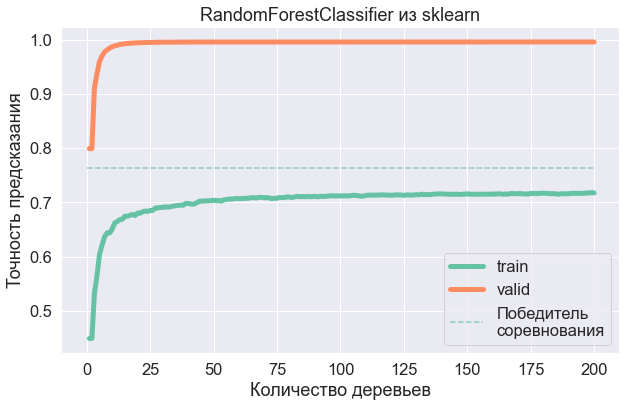

In [19]:
accuracy_train = accuracy_by_tree_count(rf, x_valid, y_valid)
accuracy_valid = accuracy_by_tree_count(rf, x_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_estimators) + 1, accuracy_train, 
         lw=5, label='train')
plt.plot(np.arange(n_estimators) + 1, accuracy_valid, 
         lw=5, label='valid')
plt.hlines(0.7639, 0, n_estimators, linestyles='--', 
           alpha=0.7, label='Победитель\nсоревнования')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность предсказания')
plt.title('RandomForestClassifier из sklearn')
plt.legend()
plt.show()

Точность на тесте

In [20]:
accuracy_score(y_test, rf.predict(x_test))

0.72158

**Leaderboard моделей**

| Место | Имя модели  | Тип данных | Качество на валидации | Качество на тесте |
|----------------|-------------|-------------|-----------------------|----------------|
| 1     | Победитель  |  |      | 0.7639         |
| 2     | RandomForestClassifier  | C | 0.7175                 | 0.72158         |

Далее рассмотрим еще несколько моделей, в которых проделаем аналогичные операции.

## 4. GradientBoostingClassifier

Подберем гиперпараметры бустинга на **Данных C**

In [21]:
%%time

n_estimators = 200
test_model = GradientBoostingClassifier(
    n_estimators=100, random_state=42
).fit(x_train, y_train)

CPU times: user 3min 5s, sys: 2.94 ms, total: 3min 5s
Wall time: 3min 5s


In [22]:
model = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42), 
    param_distributions={
        'max_depth': np.arange(3, 6), 
        'n_estimators': np.arange(10, 200),
        'learning_rate': np.linspace(0.05, 0.3, 300)
    },
    cv=5, 
    verbose=1, 
    n_jobs=-2, 
    n_iter=30, 
    random_state=42
)

model.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-2,
                   param_distributions={'learning_rate': array([0.05      , 0.05083612, 0.05167224, 0.05250836, 0.05334448,
       0.0541806 , 0.05501672, 0.05585284, 0.05668896, 0.05752508,
       0.0583612 , 0.05919732, 0.06003344, 0.06086957, 0.06170569,
       0.06254181, 0.06337793, 0.06421405, 0.06505017, 0.06588...
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199])},
                   random_state=42, verbose=1)

In [23]:
accuracy_score(y_valid, model.predict(x_valid))

0.7378

Делаем предсказания модели в зависимости от количества деревьев и считаем метрику

In [24]:
predictions_train = model.best_estimator_.staged_predict(x_train)
predictions_valid = model.best_estimator_.staged_predict(x_valid)
accuracy_train = [accuracy_score(y_train, p) for p in predictions_train]
accuracy_valid = [accuracy_score(y_valid, p) for p in predictions_valid]

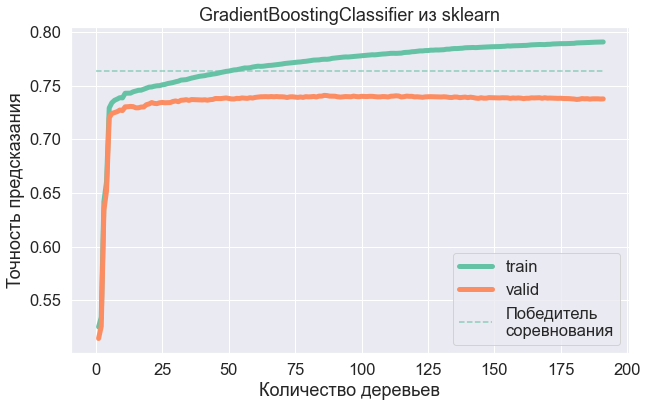

In [25]:
n_estimators = model.best_params_['n_estimators']

plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_estimators) + 1, accuracy_train, 
         lw=5, label='train')
plt.plot(np.arange(n_estimators) + 1, accuracy_valid, 
         lw=5, label='valid')
plt.hlines(0.7639, 0, n_estimators, linestyles='--', 
           alpha=0.7, label='Победитель\nсоревнования')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность предсказания')
plt.title('GradientBoostingClassifier из sklearn')
plt.legend()
plt.show()

In [26]:
accuracy_score(y_test, model.predict(x_test))

0.74456

**Leaderboard моделей**

| Место | Имя модели  | Тип данных | Качество на валидации | Качество на тесте |
|----------------|-------------|-------------|-----------------------|----------------|
| 1     | Победитель  |  |      | 0.7639         |
| 2     | GradientBoostingClassifier | C | 0.7378               | 0.74456         |
| 3     | RandomForestClassifier  | C | 0.7175                 | 0.72158         |


## 5. RandomForestClassifier + OneHotEncoder

Попробуем иначе кодировать категориальные признаки.

**Данные D** &mdash; данные, полученные из **Данных A** с помощью заполненяия пропусков в вещественных признаках средним значением и с помощью OneHotEncoder на категориальных.

In [27]:
oh_encoder = OneHotEncoder(handle_unknown='ignore')
cat_train = oh_encoder.fit_transform(x_train_origin[text_features])
cat_valid = oh_encoder.transform(x_valid_origin[text_features])
cat_test = oh_encoder.transform(x_test_origin[text_features])

In [28]:
cat_train

<40000x9236 sparse matrix of type '<class 'numpy.float64'>'
	with 760000 stored elements in Compressed Sparse Row format>

Соединяем кодировку категориальных с вещественными признаким

In [29]:
x_train_sparse = sparse.hstack([
    cat_train, sparse.coo_matrix(x_train[real_features])
])
x_valid_sparse = sparse.hstack([
    cat_valid, sparse.coo_matrix(x_valid[real_features])
])
x_test_sparse = sparse.hstack([
    cat_test, sparse.coo_matrix(x_test[real_features])
])

In [30]:
%%time

n_estimators = 200
rf = RandomForestClassifier(
    n_estimators=n_estimators, random_state=42, n_jobs=4
).fit(x_train_sparse, y_train)

CPU times: user 2min 20s, sys: 200 ms, total: 2min 21s
Wall time: 35.6 s


In [31]:
accuracy_score(y_valid, rf.predict(x_valid_sparse))

0.6084

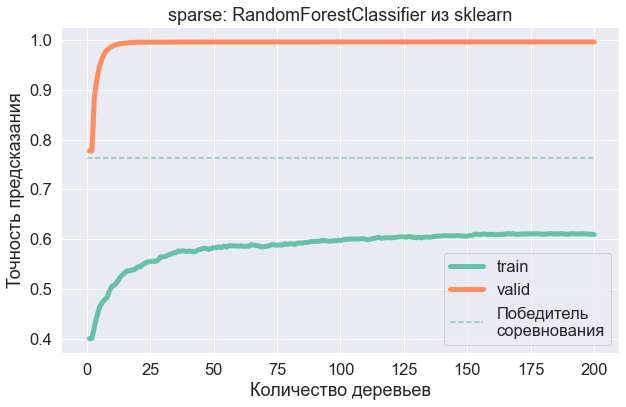

In [32]:
accuracy_train = accuracy_by_tree_count(rf, x_valid_sparse, y_valid)
accuracy_valid = accuracy_by_tree_count(rf, x_train_sparse, y_train)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_estimators) + 1, accuracy_train, 
         lw=5, label='train')
plt.plot(np.arange(n_estimators) + 1, accuracy_valid, 
         lw=5, label='valid')
plt.hlines(0.7639, 0, n_estimators, linestyles='--', 
           alpha=0.7, label='Победитель\nсоревнования')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность предсказания')
plt.title('sparse: RandomForestClassifier из sklearn')
plt.legend()
plt.show()

In [33]:
accuracy_score(y_test, rf.predict(x_test_sparse))

0.61658

**Leaderboard моделей**

| Место | Имя модели  | Тип данных | Качество на валидации | Качество на тесте |
|----------------|-------------|-------------|-----------------------|----------------|
| 1     | Победитель  |  |      | 0.7639         |
| 2     | GradientBoostingClassifier | C | 0.7378               | 0.74456         |
| 3     | RandomForestClassifier  | C | 0.7175                 | 0.72158         |
| 4     | RandomForestClassifier | D  | 0.6084             | 0.61658         |

Ну тут совсем налажали...

## 6. XGBoost

Выкатываем тяжелую артиллерию. Она умеет работать с пропусками, поэтому берем **Данные B**

In [34]:
%%time

n_estimators = 200
test_model = XGBClassifier(
    n_estimators=n_estimators, random_state=42, eval_metric='merror'
).fit(x_train_encoder, y_train)

CPU times: user 8min 3s, sys: 3.68 s, total: 8min 7s
Wall time: 40.9 s


In [35]:
model = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='merror'), 
    param_distributions={
        'max_depth': np.arange(3, 8), 
        'n_estimators': np.arange(10, 200),
        'learning_rate': np.linspace(0.05, 0.3, 300)
    },
    cv=5, 
    verbose=1, 
    n_jobs=1, 
    n_iter=30, 
    random_state=42
)

model.fit(x_train_encoder, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='merror', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan...
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 

In [36]:
accuracy_score(y_valid, model.predict(x_valid_encoder))

0.7362

Делаем предсказания модели в зависимости от количества деревьев и считаем метрику

In [37]:
n_estimators = model.best_params_['n_estimators']

accuracy_train = [
    accuracy_score(
        y_train, model.best_estimator_.predict(x_train_encoder, 
                                               ntree_limit=i+1)
    )
    for i in range(n_estimators)
]

accuracy_valid = [
    accuracy_score(
        y_valid, model.best_estimator_.predict(x_valid_encoder, 
                                               ntree_limit=i+1)
    )
    for i in range(n_estimators)
]

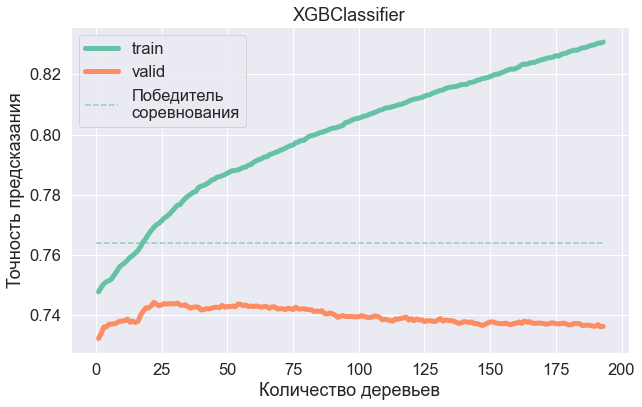

In [38]:
n_estimators = model.best_params_['n_estimators']

plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_estimators) + 1, accuracy_train, 
         lw=5, label='train')
plt.plot(np.arange(n_estimators) + 1, accuracy_valid, 
         lw=5, label='valid')
plt.hlines(0.7639, 0, n_estimators, linestyles='--', 
           alpha=0.7, label='Победитель\nсоревнования')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность предсказания')
plt.title('XGBClassifier')
plt.legend()
plt.show()

In [39]:
accuracy_score(y_test, model.predict(x_test_encoder))

0.7444

**Leaderboard моделей**

| Место | Имя модели  | Тип данных | Качество на валидации | Качество на тесте |
|----------------|-------------|-------------|-----------------------|----------------|
| 1     | Победитель  |  |      | 0.7639         |
| 2     | GradientBoostingClassifier | C | 0.7378               | 0.74456         |
| 3     | XGBClassifier | B | 0.7362                | 0.7444         |
| 4     | RandomForestClassifier  | C | 0.7175                 | 0.72158         |
| 5     | RandomForestClassifier | D  | 0.6084             | 0.61658         |


Лучше не стало.

## 7. LGBMClassifier

Другая <s>тяжелая</s> легкая артиллерия с **Данными B**

In [40]:
model = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42), 
    param_distributions={
        'max_depth': np.arange(3, 6), 
        'n_estimators': np.arange(10, 100),
        'learning_rate': np.linspace(0.05, 0.3, 300)
    },
    cv=5, 
    verbose=1, 
    n_jobs=1, 
    n_iter=30, 
    random_state=42
)

model.fit(x_train_encoder, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=30,
                   n_jobs=1,
                   param_distributions={'learning_rate': array([0.05      , 0.05083612, 0.05167224, 0.05250836, 0.05334448,
       0.0541806 , 0.05501672, 0.05585284, 0.05668896, 0.05752508,
       0.0583612 , 0.05919732, 0.06003344, 0.06086957, 0.06170569,
       0.06254181, 0.06337793, 0.06421405, 0.06505017, 0.06588629,
       0.0667224...
       0.29665552, 0.29749164, 0.29832776, 0.29916388, 0.3       ]),
                                        'max_depth': array([3, 4, 5]),
                                        'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 

In [41]:
accuracy_score(y_valid, model.predict(x_valid_encoder))

0.7418

In [42]:
n_estimators = model.best_params_['n_estimators']

accuracy_train = [
    accuracy_score(
        y_train, model.best_estimator_.predict(x_train_encoder, 
                                               num_iteration=i+1)
    )
    for i in range(n_estimators)
]

accuracy_valid = [
    accuracy_score(
        y_valid, model.best_estimator_.predict(x_valid_encoder, 
                                               num_iteration=i+1)
    )
    for i in range(n_estimators)
]

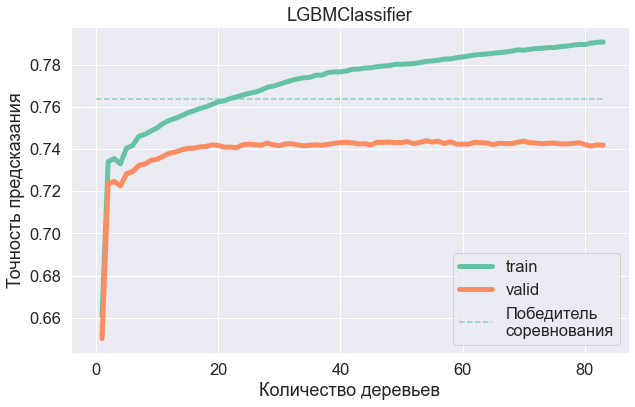

In [43]:
n_estimators = model.best_params_['n_estimators']

plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_estimators) + 1, accuracy_train, 
         lw=5, label='train')
plt.plot(np.arange(n_estimators) + 1, accuracy_valid, 
         lw=5, label='valid')
plt.hlines(0.7639, 0, n_estimators, linestyles='--', 
           alpha=0.7, label='Победитель\nсоревнования')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность предсказания')
plt.title('LGBMClassifier')
plt.legend()
plt.show()

In [44]:
accuracy_score(y_test, model.predict(x_test_encoder))

0.7458

**Leaderboard моделей**

| Место | Имя модели  | Тип данных | Качество на валидации | Качество на тесте |
|----------------|-------------|-------------|-----------------------|----------------|
| 1     | Победитель  |  |      | 0.7639         |
| 2     | LGBMClassifier | B | 0.7418                | 0.7458         |
| 3     | GradientBoostingClassifier | C | 0.7378               | 0.74456         |
| 4     | XGBClassifier | B | 0.7362                | 0.7444         |
| 5     | RandomForestClassifier  | C | 0.7175                 | 0.72158         |
| 6     | RandomForestClassifier | D  | 0.6084             | 0.61658         |

Качество примерно такое же. Плюс в том, что обучение прошло очень быстро. Так и не подумаешь, что эта модель -- разработка Microsoft...

## 8. CatBoostClassifier

Приятно то, что катбуст сам обрабатывает категориальные признаки, нужно только подать ему их индексы. Поэтому используем **Данные A**, которые почти не отличаются от исходных.

In [45]:
# задаем пространство поиска
param_distributions = {
    'n_estimators' : np.arange(1, 200),
    'max_depth' : list(range(3, 8)),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    'rsm' : np.linspace(0.5, 1, 100)
}


# определяем поиск по сетке 
model = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=text_features, 
                                 silent=True),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=30,
    n_jobs=1,
    cv=5,
    verbose=1,
    error_score='raise',
    random_state=42
)

In [46]:
model.fit(x_train_origin, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f6fbeaaed30>,
                   n_iter=30, n_jobs=1,
                   param_distributions={'l2_leaf_reg': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5...
       0.85353535, 0.85858586, 0.86363636, 0.86868687, 0.87373737,
       0.87878788, 0.88383838, 0.88888889, 0.89393939, 0.8989899 ,
       0.9040404 , 0.90909091, 0.91414141, 0.91919192, 0.92424242,
       0.92929293, 0.93434343, 0.93939394, 0.94444444, 0.94949495,
       0.95454545, 0.95959596, 0.96464646, 0.96969697, 0.97474747,
       0.97979798, 0.98484848, 0.98989899, 0.99494949, 1.        ])},
                   random_state=42, scoring='accura

In [47]:
accuracy_score(y_valid, model.predict(x_valid_origin))

0.7535

In [48]:
n_estimators = model.best_params_['n_estimators']

accuracy_train = [
    accuracy_score(
        y_train, model.best_estimator_.predict(x_train_origin, 
                                               ntree_end=i+1)
    )
    for i in range(n_estimators)
]

accuracy_valid = [
    accuracy_score(
        y_valid, model.best_estimator_.predict(x_valid_origin, 
                                               ntree_end=i+1)
    )
    for i in range(n_estimators)
]

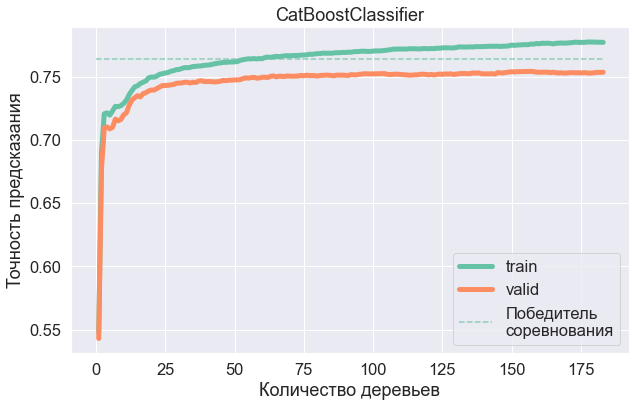

In [49]:
n_estimators = model.best_params_['n_estimators']

plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_estimators) + 1, accuracy_train, lw=5, label='train')
plt.plot(np.arange(n_estimators) + 1, accuracy_valid, lw=5, label='valid')
plt.hlines(0.7639, 0, n_estimators, linestyles='--', 
           alpha=0.7, label='Победитель\nсоревнования')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность предсказания')
plt.title('CatBoostClassifier')
plt.legend()
plt.show()

In [50]:
accuracy_score(y_test, model.predict(x_test_origin))

0.75898

**Leaderboard моделей**

| Место | Имя модели  | Тип данных | Качество на валидации | Качество на тесте |
|----------------|-------------|-------------|-----------------------|----------------|
| 1     | Победитель  |  |      | 0.7639         |
| 2     | CatBoostClassifier | A | 0.7535              | 0.75898         |
| 3     | LGBMClassifier | B | 0.7418                | 0.7458         |
| 4     | GradientBoostingClassifier | C | 0.7378               | 0.74456         |
| 5     | XGBClassifier | B | 0.7362                | 0.7444         |
| 6     | RandomForestClassifier  | C | 0.7175                 | 0.72158         |
| 7     | RandomForestClassifier | D  | 0.6084             | 0.61658         |


Теперь от победителя нас отделяют менее 0.5% качества.